#### 代码介绍
    由于使用了LSTM，时间窗口对于数据的预测效果有着很大的影响，所以固定预测图像以及模型架构，采用3~10的时间窗口运行模型得到评估指标，根据评估指标选择最为合适的时间窗口

In [1]:
import os
import re
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 从文件名中提取数字的辅助函数
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

# 加载并排序图像文件
def load_images_sorted(directory):
    images = []
    for fname in os.listdir(directory):
        if fname.endswith('.jpg'):
            full_path = os.path.join(directory, fname)
            images.append(full_path)
    images.sort(key=extract_number)
    return images

# 从文件名中提取风暴ID和时间的辅助函数
def extract_storm_id_and_time(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    storm_id = parts[0]
    time = parts[1].split('.')[0]
    return storm_id, time

# 提取所有图像信息的辅助函数
def extract_all_image_info(image_paths):
    all_image_info = []
    for path in image_paths:
        storm_id, time = extract_storm_id_and_time(path)
        all_image_info.append((storm_id, time))
    return all_image_info

# 数据目录
directory = '/root/dashuju/data2'
all_images = load_images_sorted(directory)
split_point = int(len(all_images) * 0.8)
train_images = all_images[:split_point]
val_images = all_images[split_point:]

# 提取训练集和验证集的所有图片信息
train_image_info = extract_all_image_info(train_images)
val_image_info = extract_all_image_info(val_images)

# 数据集类定义
class TyphoonDataset(Dataset):
    def __init__(self, image_paths, sequence_length=10, transform=None):
        self.image_paths = image_paths
        self.sequence_length = sequence_length
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.image_paths) - self.sequence_length + 1

    def __getitem__(self, idx):
        sequence_paths = self.image_paths[idx:idx + self.sequence_length]
        imgs = [Image.open(img_path).convert('RGB') for img_path in sequence_paths]
        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        sequences = torch.stack(imgs[:-1])
        target = imgs[-1]  # 确保目标图像是 [1, height, width]
        return sequences, target

# 创建数据集和数据加载器
train_dataset = TyphoonDataset(train_images, sequence_length=4)  # 包含10个输入帧和1个输出帧
val_dataset = TyphoonDataset(val_images, sequence_length=4)
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, drop_last=True)
"""
# 打印训练集和验证集的图片信息
print("Training set image info:")
for info in train_image_info:
    print(info)

print("\nValidation set image info:")
for info in val_image_info:
    print(info)
"""

'\n# 打印训练集和验证集的图片信息\nprint("Training set image info:")\nfor info in train_image_info:\n    print(info)\n\nprint("\nValidation set image info:")\nfor info in val_image_info:\n    print(info)\n'

In [2]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim, bias=True):
        super(ConvLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.bias = bias
        self.cell_list = nn.ModuleList()
        
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            self.cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                               hidden_dim=self.hidden_dim[i],
                                               kernel_size=self.kernel_size,
                                               bias=self.bias))
        
        self.conv = nn.Conv2d(in_channels=self.hidden_dim[-1],
                              out_channels=self.output_dim,
                              kernel_size=1,
                              padding=0,
                              bias=True)

    def forward(self, input_tensor, hidden_state=None):
        b, seq_len, _, h, w = input_tensor.size()
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))
        
        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append((h, c))

        predictions = self.conv(layer_output_list[-1][:, -1, :, :, :])
        return predictions, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states


In [3]:
import torch.optim as optim

In [4]:
# 初始化模型、损失函数和优化器
model = ConvLSTM(input_dim=1, hidden_dim=[64, 64], kernel_size=(1, 1), num_layers=2, output_dim=1, bias=True)
model.cuda()  # 如果有GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

for epoch in range(15):  # 设置所需的epoch数
    model.train()
    total_train_loss = 0
    for sequences, targets in train_loader:
        sequences = sequences.cuda()
        targets = targets.cuda()  # 确保目标维度是正确的 [batch_size, 1, height, width]
        optimizer.zero_grad()
        outputs, _ = model(sequences)
        train_loss = criterion(outputs, targets)
        train_loss.backward()
        optimizer.step()
        total_train_loss += train_loss.item()
    train_losses.append(total_train_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences = sequences.cuda()
            targets = targets.cuda()
            outputs, _ = model(sequences)
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()
    val_losses.append(total_val_loss / len(val_loader))
    print(f'Epoch {epoch+1}, Train Loss: {total_train_loss / len(train_loader)}, Validation Loss: {total_val_loss / len(val_loader)}')

Epoch 1, Train Loss: 0.045385523052472204, Validation Loss: 0.011991470067117076
Epoch 2, Train Loss: 0.011625597240506776, Validation Loss: 0.005473363598307164
Epoch 3, Train Loss: 0.01016785085839392, Validation Loss: 0.005172733208522773
Epoch 4, Train Loss: 0.009653584307266606, Validation Loss: 0.004821932597014193
Epoch 5, Train Loss: 0.009033757777177487, Validation Loss: 0.004369643919814665
Epoch 6, Train Loss: 0.00823711297750749, Validation Loss: 0.003801436127664951
Epoch 7, Train Loss: 0.007176385888467646, Validation Loss: 0.003156939843812814
Epoch 8, Train Loss: 0.006256947837149103, Validation Loss: 0.0028456547387087573
Epoch 9, Train Loss: 0.006117161591882231, Validation Loss: 0.0028035613941028714
Epoch 10, Train Loss: 0.0061130192846542706, Validation Loss: 0.002798655750946357
Epoch 11, Train Loss: 0.006104264300558026, Validation Loss: 0.0027946232540461305
Epoch 12, Train Loss: 0.006097581729085909, Validation Loss: 0.0027912922713977215
Epoch 13, Train Loss: 

In [5]:
for sequences, targets in train_loader:
    sequences = sequences.cuda()
    targets = targets.cuda()
    outputs, _ = model(sequences)
    print("Output size:", outputs.size())  # 现在检查输出尺寸
    print("Target size:", targets.size())  # 检查目标尺寸
    break  # 仅检查第一个批次

Output size: torch.Size([3, 1, 128, 128])
Target size: torch.Size([3, 1, 128, 128])


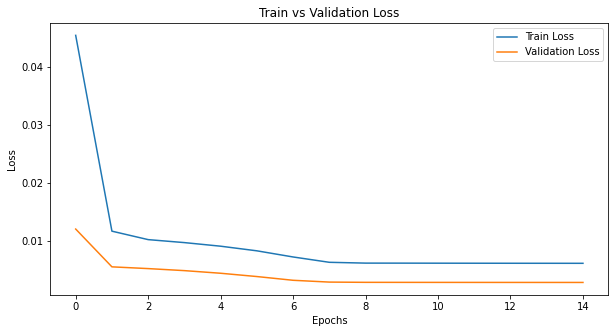

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
import torch

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/root/dashuju/model/寻优窗口3.pth')

预测和绘图代码

In [8]:
# 反归一化函数
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # 反归一化到 [0, 1]
    tensor = tensor * 255.0  # 反归一化到 [0, 255]
    tensor = tensor.clamp(0, 255)  # 确保像素值在 [0, 255] 范围内
    return tensor.byte()  # 转换为无符号 8 位整数

In [9]:
# 计算信息熵
def calculate_entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)
    e = entropy(hist, base=2)
    return e

In [10]:
# 绘制图像的函数
def plot_and_save_images(images, titles=None, title='Images', save_path=''):
    num_images = len(images)
    fig, axes = plt.subplots(2, num_images // 2, figsize=(20, 10))
    axes = axes.flatten()
    for i, img_tensor in enumerate(images):
        if isinstance(img_tensor, torch.Tensor):
            # img_tensor = denormalize(img_tensor)  # 反归一化
            img = transforms.ToPILImage()(img_tensor)  # 转换为 PIL 图像
        else:
            img = img_tensor
        axes[i].imshow(img, cmap='gray')
        if titles:
            axes[i].set_title(titles[i], fontsize=10)
        axes[i].axis('off')
    fig.suptitle(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

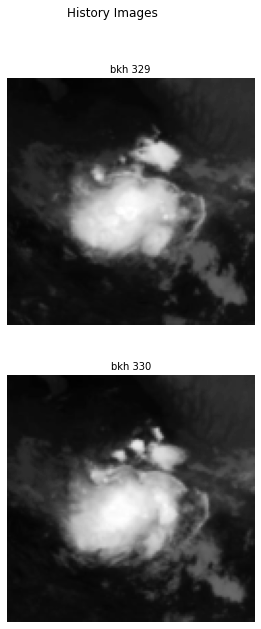

ConvLSTM(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [11]:
# 设置保存目录
output_dir = '/root/dashuju/predicted_images'
os.makedirs(output_dir, exist_ok=True)

# 从验证集提取历史图像路径和标签
history_image_paths = val_images[:2]
history_titles = [f'{extract_storm_id_and_time(path)[0]} {extract_storm_id_and_time(path)[1]}' for path in history_image_paths]

# 显示历史图像
val_sequences, val_targets = next(iter(val_loader))
history_images = [val_sequences[0][i] for i in range(2)]
plot_and_save_images(history_images, history_titles, title="History Images", save_path=os.path.join(output_dir, '寻优窗口3history_images.png'))

# 预测图像和真实图像的标签
predicted_titles = [f'Predicted Frame {i+1} ({val_image_info[2 + i][0]} {val_image_info[2 + i][1]})' for i in range(2)]
real_titles = [f'Real Frame {i+1} ({val_image_info[2 + i][0]} {val_image_info[4 + i][1]})' for i in range(2)]
combined_titles = predicted_titles + real_titles

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [12]:
import matplotlib.pyplot as plt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 从验证集中选取一个样本
val_sequences, val_targets = next(iter(val_loader))
initial_sequence = val_sequences[0:1].to(device)  # 选择第一个样本

predicted_images = []
current_sequence = initial_sequence

# 进行三次连续预测
for _ in range(3):
    with torch.no_grad():
        prediction, _ = model(current_sequence)
        prediction = prediction.unsqueeze(1)  # 确保维度正确
        predicted_images.append(prediction.cpu().squeeze(0).squeeze(0))
        
        # 更新序列：移除第一帧，加入新预测的帧
        current_sequence = torch.cat((current_sequence[:, 1:, :, :, :], prediction), dim=1)

# 从val_targets提取真实的未来三帧图像
real_future_images = [val_targets[i].cpu() for i in range(3)]


Image 1:
MSE: 0.0019
PSNR: 75.25 dB
SSIM: 0.9999
Entropy (Real): 6.6201
Entropy (Pred): 6.5528
---------------------------
Image 2:
MSE: 0.0049
PSNR: 71.26 dB
SSIM: 0.9996
Entropy (Real): 6.5957
Entropy (Pred): 6.4835
---------------------------
Image 3:
MSE: 0.0069
PSNR: 69.77 dB
SSIM: 0.9993
Entropy (Real): 6.5167
Entropy (Pred): 6.4072
---------------------------


IndexError: list index out of range

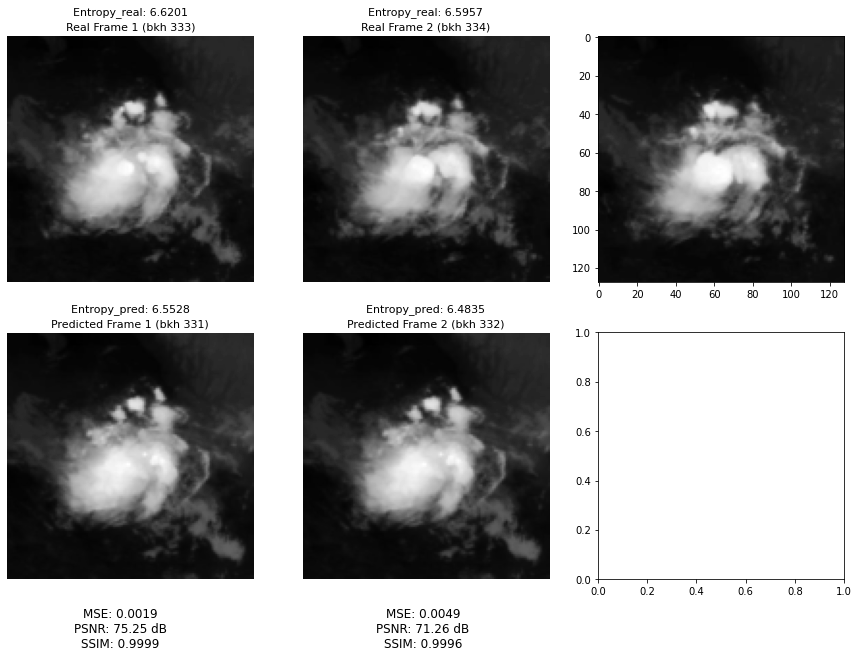

In [13]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.stats import entropy

# 设置保存目录
output_dir = '/root/dashuju/predicted_images'
os.makedirs(output_dir, exist_ok=True)

# 反归一化函数
def denormalize(tensor):
    return tensor * 255.0

# 计算信息熵的辅助函数
def calculate_entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)
    e = entropy(hist, base=2)
    return e

# 计算评估指标和信息熵
metrics = {
    'mse': [],
    'psnr': [],
    'ssim': [],
    'entropy_real': [],
    'entropy_pred': []
}

for real_img, pred_img in zip(real_future_images, predicted_images):
    real_img_np = real_img.squeeze().cpu().numpy() 
    pred_img_np = pred_img.squeeze().cpu().numpy()
    
    mse = mean_squared_error(real_img_np, pred_img_np)
    psnr = peak_signal_noise_ratio(real_img_np, pred_img_np, data_range=255)
    ssim = structural_similarity(real_img_np, pred_img_np, data_range=255)
    entropy_real = calculate_entropy(real_img_np)
    entropy_pred = calculate_entropy(pred_img_np)
    
    metrics['mse'].append(mse)
    metrics['psnr'].append(psnr)
    metrics['ssim'].append(ssim)
    metrics['entropy_real'].append(entropy_real)
    metrics['entropy_pred'].append(entropy_pred)

    # 在控制台输出指标值
    print(f'Image {len(metrics["mse"])}:')
    print(f'MSE: {mse:.4f}')
    print(f'PSNR: {psnr:.2f} dB')
    print(f'SSIM: {ssim:.4f}')
    print(f'Entropy (Real): {entropy_real:.4f}')
    print(f'Entropy (Pred): {entropy_pred:.4f}')
    print('---------------------------')

# 绘制预测图像和真实图像，并显示评估指标和信息熵
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (real_img, pred_img) in enumerate(zip(real_future_images, predicted_images)):
    real_img_np = real_img.squeeze().cpu().numpy()
    pred_img_np = pred_img.squeeze().cpu().numpy()

    if real_img_np.ndim == 3 and real_img_np.shape[0] == 1:  # 如果是灰度图像，移除通道维度
        real_img_np = real_img_np.squeeze(0)
    if pred_img_np.ndim == 3 and pred_img_np.shape[0] == 1:  # 如果是灰度图像，移除通道维度
        pred_img_np = pred_img_np.squeeze(0)

    axes[0, i].imshow(real_img_np, cmap='gray')
    axes[0, i].set_title(real_titles[i], fontsize=11)
    axes[0, i].axis('off')
    axes[0, i].text(0.5, 1.12, f'Entropy_real: {metrics["entropy_real"][i]:.4f}', ha='center', va='top', transform=axes[0, i].transAxes, fontsize=11)
    
    axes[1, i].imshow(pred_img_np, cmap='gray')
    axes[1, i].set_title(predicted_titles[i], fontsize=11)
    axes[1, i].axis('off')
    axes[1, i].text(0.5, 1.12, f'Entropy_pred: {metrics["entropy_pred"][i]:.4f}', ha='center', va='top', transform=axes[1, i].transAxes, fontsize=11)

    # 显示评估指标
    metric_text = f'MSE: {metrics["mse"][i]:.4f}\nPSNR: {metrics["psnr"][i]:.2f} dB\nSSIM: {metrics["ssim"][i]:.4f}'
    fig.text(0.23 + 0.28 * i, 0.03, metric_text, ha='center', fontsize=12)  # 调整 x 位置

plt.subplots_adjust(top=0.85)
plt.suptitle("Predicted vs Real Future Images", fontsize=15)
plt.savefig(os.path.join(output_dir, '寻优窗口3predicted_vs_real_images.png'))
plt.show()


In [14]:
# 假设我们有以下控制台输出数据
output_data = """
Image 1:
MSE: 0.0019
PSNR: 75.25 dB
SSIM: 0.9999
Entropy (Real): 6.6201
Entropy (Pred): 6.5528
---------------------------
Image 2:
MSE: 0.0049
PSNR: 71.26 dB
SSIM: 0.9996
Entropy (Real): 6.5957
Entropy (Pred): 6.4835
---------------------------
Image 3:
MSE: 0.0069
PSNR: 69.77 dB
SSIM: 0.9993
Entropy (Real): 6.5167
Entropy (Pred): 6.4072
"""

# 使用正则表达式提取数据
import re

entropy_real = re.findall(r'Entropy \(Real\): ([\d.]+)', output_data)
entropy_pred = re.findall(r'Entropy \(Pred\): ([\d.]+)', output_data)
mse = re.findall(r'MSE: ([\d.]+)', output_data)
psnr = re.findall(r'PSNR: ([\d.]+) dB', output_data)
ssim = re.findall(r'SSIM: ([\d.]+)', output_data)

# 将字符串转换为浮点数
entropy_real = list(map(float, entropy_real))
entropy_pred = list(map(float, entropy_pred))
mse = list(map(float, mse))
psnr = list(map(float, psnr))
ssim = list(map(float, ssim))

# 输出结果
print(f"ER={entropy_real}")
print(f"EP={entropy_pred}")
print(f"MSE={mse}")
print(f"PSNR={psnr}")
print(f"SSIM={ssim}")


ER=[6.6201, 6.5957, 6.5167]
EP=[6.5528, 6.4835, 6.4072]
MSE=[0.0019, 0.0049, 0.0069]
PSNR=[75.25, 71.26, 69.77]
SSIM=[0.9999, 0.9996, 0.9993]


### 绘制寻优窗口比较图

#### 序列窗口为10
ER=[6.3783,6.4244,6.5504]
EP=[6.3459.6.3454.6.3396]
MSE=[0.0025,0.0058,0.0096]
PSNR=[74.09,70.48,68.30]
SSIM=[0.9998,0.9994,0.9989]

#### 序列窗口为9
ER=[6.3603, 6.3783, 6.4244]
EP=[6.3642, 6.3091, 6.2412]
MSE=[0.0047, 0.0072, 0.0099]
PSNR=[71.37, 69.54, 68.17]
SSIM=[0.9995, 0.9993, 0.9989]

### 序列窗口为8
ER=[7.0725, 7.0564, 7.0617]
EP=[6.8619, 6.7832, 6.6892]
MSE=[0.0066, 0.0086, 0.0108]
PSNR=[69.96, 68.8, 67.8]
SSIM=[0.9995, 0.9993, 0.999]

### 序列窗口为7
ER=[6.3838, 6.3603, 6.3783]
EP=[6.3158, 6.2097, 6.1153]
MSE=[0.0026, 0.0065, 0.0102]
PSNR=[74.0, 70.01, 68.05]
SSIM=[0.9998, 0.9993, 0.9988]

### 序列窗口为6
ER=[6.4265, 6.3838, 6.3603]
EP=[6.3857, 6.2526, 6.1221]
MSE=[0.0045, 0.0078, 0.0119]
PSNR=[71.56, 69.21, 67.39]
SSIM=[0.9996, 0.9992, 0.9986]

### 序列窗口为5
ER=[6.5167, 6.4265, 6.3838]
EP=[6.4407, 6.299, 6.1718]
MSE=[0.0021, 0.0073, 0.0105]
PSNR=[74.97, 69.52, 67.91]
SSIM=[0.9998, 0.9992, 0.9988]

### 序列窗口为4
ER=[6.5957, 6.5167, 6.4265]
EP=[6.5426, 6.4529, 6.3595]
MSE=[0.0021, 0.0045, 0.0086]
PSNR=[74.81, 71.55, 68.78]
SSIM=[0.9998, 0.9996, 0.9991]

### 序列窗口为3
ER=[6.6201, 6.5957, 6.5167]
EP=[6.5528, 6.4835, 6.4072]
MSE=[0.0019, 0.0049, 0.0069]
PSNR=[75.25, 71.26, 69.77]
SSIM=[0.9999, 0.9996, 0.9993]

### 图像质量评估指标

#### 1. 平均相对误差 (ER)
ER（Error Rate）表示模型预测值与真实值之间的平均相对误差，数值越小，说明预测越准确。计算公式为：
$$
ER = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$
其中，$y_i$ 为真实值，$\hat{y}_i$ 为预测值，$n$ 为样本数量。

#### 2. 预测平均值 (EP)
EP（Estimated Prediction）表示模型对目标值的平均预测水平，数值越接近真实值，说明模型预测效果越好。计算公式为：
$$
EP = \frac{1}{n} \sum_{i=1}^{n} \hat{y}_i
$$
其中，$\hat{y}_i$ 为预测值，$n$ 为样本数量。

#### 3. 均方误差 (MSE)
MSE（Mean Squared Error）表示预测值与真实值之间误差的平方平均，数值越小，说明模型预测越准确。计算公式为：
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2
$$
其中，$y_i$ 为真实值，$\hat{y}_i$ 为预测值，$n$ 为样本数量。

#### 4. 峰值信噪比 (PSNR)
PSNR（Peak Signal-to-Noise Ratio）表示图像的峰值信噪比，数值越大，表示图像质量越好。计算公式为：
$$
PSNR = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{MSE} \right)
$$
其中，$MAX_I$ 表示图像像素的最大值，一般为255。

#### 5. 结构相似性指数 (SSIM)
SSIM（Structural Similarity Index）表示两幅图像在亮度、对比度和结构上的相似性，数值范围为 [0, 1]，越接近1表示两幅图像越相似。计算公式为：
$$
SSIM(x, y) = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$
其中，$x$ 和 $y$ 表示两幅图像的像素值，$\mu_x$ 和 $\mu_y$ 为均值，$\sigma_x$ 和 $\sigma_y$ 为方差，$\sigma_{xy}$ 为协方差，$C_1$ 和 $C_2$ 为稳定常数。

### 评估标准
- **ER** 和 **MSE** 越小，说明模型预测越准确。
- **EP** 越接近真实值，说明模型预测越稳定。
- **PSNR** 越大，说明图像质量越高。
- **SSIM** 越接近1，说明图像与参考图像的结构越相似。

通过以上评估指标，可以综合判定图像的好坏，并选择最优的序列窗口。


#### 1.图像熵的对比图

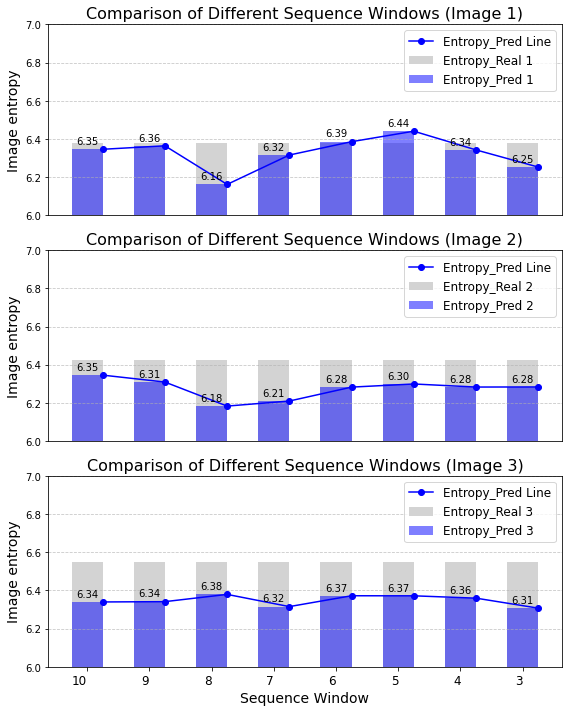

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 设置绘图风格和字体
plt.rcParams['font.family'] = 'Times New Roman'

# 序列窗口
windows = ['10', '9', '8', '7', '6', '5', '4', '3']

# 指标数据
ER = [
    [6.3783, 6.4244, 6.5504],
    [6.3783, 6.4244, 6.5504],
    [6.3783, 6.4244, 6.5504],
    [6.3783, 6.4244, 6.5504],
    [6.3783, 6.4244, 6.5504],
    [6.3783, 6.4244, 6.5504],
    [6.3783, 6.4244, 6.5504],
    [6.3783, 6.4244, 6.5504]
]
EP = [
    [6.3459, 6.3454, 6.3396],
    [6.3642, 6.3091, 6.3412],
    [6.1619, 6.1832, 6.3792],
    [6.3158, 6.2097, 6.3153],
    [6.3857, 6.2826, 6.3721],
    [6.4407, 6.299, 6.3718],
    [6.3426, 6.2829, 6.3595],
    [6.2528, 6.2835, 6.3072]
]

# 转换为numpy数组以便于处理
ER = np.array(ER)
EP = np.array(EP)

# 设置柱形图的宽度和间隔
bar_width = 0.5
indices = np.arange(len(windows))

# 创建图形
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# 绘制每个图像
for i in range(3):
    ax = axs[i]
    
    # 绘制ER柱形图，作为底色
    bars_er = ax.bar(indices, ER[:, i], bar_width, color='lightgray', label=f'Entropy_Real {i+1}', alpha=1)
    #lightgray
    # 绘制EP柱形图，重叠在ER之上
    bars_ep = ax.bar(indices, EP[:, i], bar_width, color='blue', alpha=0.5, label=f'Entropy_Pred {i+1}')

    # 设置y轴从3开始
    ax.set_ylim(6, 7)

    # 在每个EP柱子的顶部用虚线标注出到y轴上，并连接这些点形成折线
    ep_heights = []
    for bar in bars_ep:
        height = bar.get_height()
        ep_heights.append(height)
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        #ax.plot([bar.get_x() + bar.get_width() / 2, bar.get_x() + bar.get_width() / 2], [3, height], linestyle='--', color='blue')

    # 连接EP柱子的顶部形成折线
    ax.plot(indices + bar_width / 2, ep_heights, color='blue', linestyle='-', marker='o', label='Entropy_Pred Line')

    # 设置y轴标签
    ax.set_ylabel('Image entropy', fontsize=14)
    ax.set_title(f'Comparison of Different Sequence Windows (Image {i+1})', fontsize=16)

    # 仅在最下面的图中设置x轴标签
    if i == 2:
        ax.set_xticks(indices)
        ax.set_xticklabels(windows, rotation=0, ha='right', fontsize=12)
    else:
        ax.set_xticks([])

    # 设置图例
    ax.legend(fontsize=12)

    # 添加网格线
    ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Sequence Window', fontsize=14)
# 调整布局
plt.tight_layout()
plt.savefig('/root/dashuju/comparison_bar_chart_with_line.png', dpi=300, bbox_inches='tight')
plt.show()


#### 2.其他三个指标的对比图

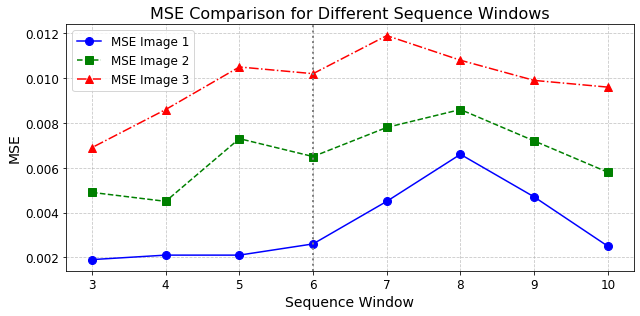

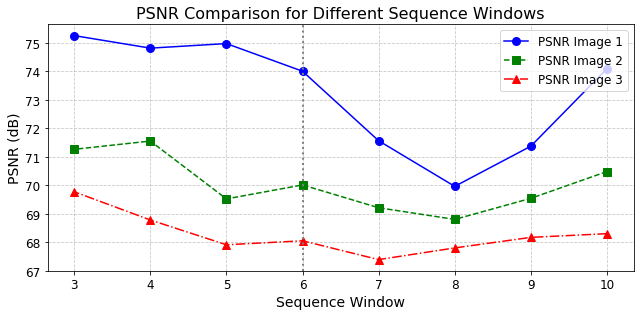

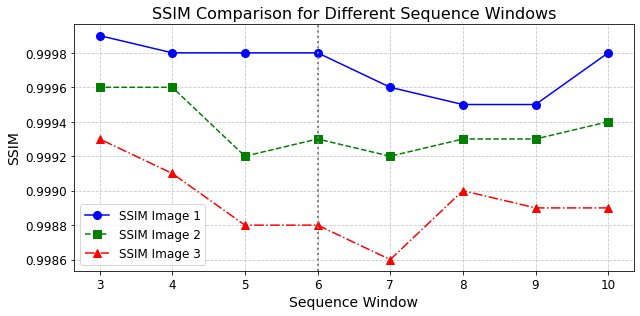

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# 设置绘图风格和字体
plt.rcParams['font.family'] = 'Times New Roman'

# 序列窗口和指标数据
windows = [10, 9, 8, 7, 6, 5, 4, 3]

MSE = [
    [0.0025, 0.0058, 0.0096],
    [0.0047, 0.0072, 0.0099],
    [0.0066, 0.0086, 0.0108],
    [0.0045, 0.0078, 0.0119],
    [0.0026, 0.0065, 0.0102],
    [0.0021, 0.0073, 0.0105],
    [0.0021, 0.0045, 0.0086],
    [0.0019, 0.0049, 0.0069]
]

PSNR = [
    [74.09, 70.48, 68.30],
    [71.37, 69.54, 68.17],
    [69.96, 68.8, 67.8],
    [71.56, 69.21, 67.39],    
    [74.0, 70.01, 68.05],
    [74.97, 69.52, 67.91],
    [74.81, 71.55, 68.78],
    [75.25, 71.26, 69.77]
]

SSIM = [
    [0.9998, 0.9994, 0.9989],
    [0.9995, 0.9993, 0.9989],
    [0.9995, 0.9993, 0.999],
    [0.9996, 0.9992, 0.9986],
    [0.9998, 0.9993, 0.9988],
    [0.9998, 0.9992, 0.9988],
    [0.9998, 0.9996, 0.9991],
    [0.9999, 0.9996, 0.9993]
]

# 转换为numpy数组以便于处理
MSE = np.array(MSE)
PSNR = np.array(PSNR)
SSIM = np.array(SSIM)

# 定义颜色和线型
colors = ['blue', 'green', 'red']
line_styles = ['-', '--', '-.']

# 优化绘图
def plot_metric(metric, metric_name, ylabel, filename, marker_styles):
    plt.figure(figsize=(9, 4.5))
    for i in range(3):
        plt.plot(windows, metric[:, i], color=colors[i], linestyle=line_styles[i], marker=marker_styles[i], markersize=8, label=f'{metric_name} Image {i+1}')
    
        # 绘制灰色的粗虚线，表示序列窗口为6的位置
    plt.axvline(x=6, color='gray', linestyle=':', linewidth=2)
    
    plt.xlabel('Sequence Window', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(f'{metric_name} Comparison for Different Sequence Windows', fontsize=16)
    plt.xticks(windows, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# 绘制MSE图像
plot_metric(MSE, 'MSE', 'MSE', '/root/dashuju/mse_comparison.png', ['o', 's', '^'])

# 绘制PSNR图像
plot_metric(PSNR, 'PSNR', 'PSNR (dB)', '/root/dashuju/psnr_comparison.png', ['o', 's', '^'])

# 绘制SSIM图像
plot_metric(SSIM, 'SSIM', 'SSIM', '/root/dashuju/ssim_comparison.png', ['o', 's', '^'])


综上，认为最优窗口为6